# Tracking the Growth of COVID-19 Cases in US

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

## Curve Fitting Global COVID-19 Cases

In [2]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]

## US COVID-19 Analysis

In [3]:
datadir = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv( datadir + 'time_series_covid19_confirmed_US.csv')
#df = pd.read_csv( datadir + 'time_series_covid19_deaths_US.csv')

In [4]:
uscases = df

# For some reason they change column names, change them back.
uscases.rename(columns={
    'Country_Region':'Country/Region',
    'Province_State':'Province/State',
    'Long_':'Long'
}, inplace=True)


# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

# global
# Province/State,Country/Region,Lat,Long,1/22/20

# US
# UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/2020

# Province/State  Country/Region      Lat     Long  1/22/20
uscases = uscases.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'])

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()

mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary.head()



Number of confirmed US COVID-19 cases by state as of 4/6/20


,4/6/20
Province/State,
New York,131815
New Jersey,41090
Michigan,17221
California,16019
Louisiana,14867
Massachusetts,13837
Florida,13324
Pennsylvania,13127
Illinois,12262


## Curve Fitting US COVID-19 Cases

                      4/6/20
Province/State              
New York              131815
New Jersey             41090
Michigan               17221
California             16019
Louisiana              14867
Massachusetts          13837
Florida                13324
Pennsylvania           13127
Illinois               12262
Washington              8311
Texas                   8043
Georgia                 7314
Connecticut             6906
Colorado                5183
Indiana                 4956
Ohio                    4453
Maryland                4045
Tennessee               3802
North Carolina          2962
Virginia                2878
Missouri                2736
Arizona                 2732
Wisconsin               2449
South Carolina          2232
Nevada                  1953
Alabama                 1952
Mississippi             1738
Utah                    1680
Oklahoma                1329
Idaho                   1101
District of Columbia    1097
Rhode Island            1082
Oregon        

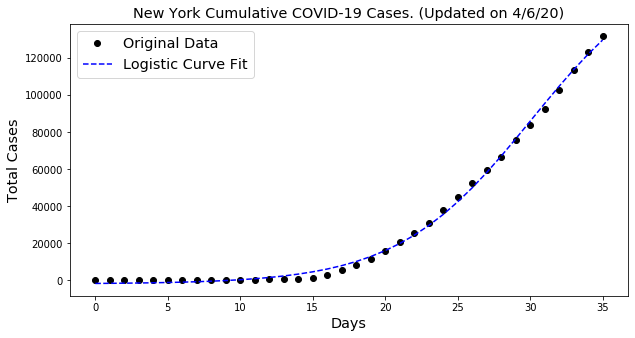



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 41090
	Confirmed cases on 3/30/20 	 16636
	Ratio: 2.47
	Weekly increase: 147.0 %
	Daily increase: 13.8 % per day
	Doubling Time (represents recent growth): 5.4 days

** Based on Logistic Fit**

	R^2: 0.9991529267661449
	Doubling Time (during middle of growth):  5.29 (± 0.3 ) days
	param:  [ 1.83788787e+03  2.61990844e-01 -2.89781496e+02  5.81546097e+04]

** Based on Exponential Fit **

	R^2: 0.9705749389281361
	Doubling Time (represents overall growth):  3.6 (± 0.5 ) days
	param:  [100.           0.19264998 100.        ]


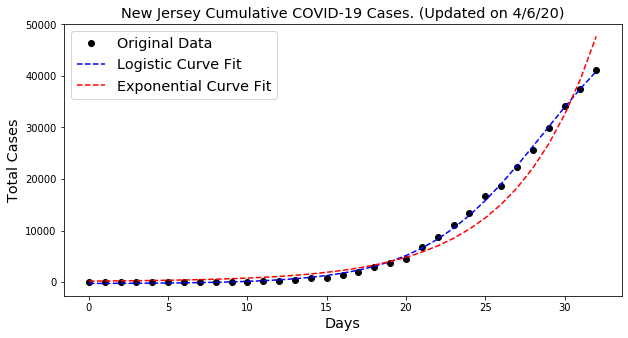



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 17221
	Confirmed cases on 3/30/20 	 6498
	Ratio: 2.65
	Weekly increase: 165.0 %
	Daily increase: 14.9 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9994820365535046
	Doubling Time (during middle of growth):  5.64 (± 0.32 ) days
	param:  [ 3.09697399e+02  2.45751798e-01 -2.16039354e+02  2.63575074e+04]

** Based on Exponential Fit **

	R^2: 0.9590353308230162
	Doubling Time (represents overall growth):  3.4 (± 0.64 ) days
	param:  [100.           0.20402285 100.        ]


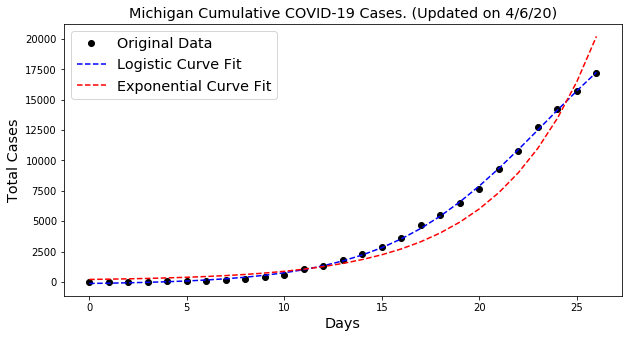



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 16019
	Confirmed cases on 3/30/20 	 7138
	Ratio: 2.24
	Weekly increase: 124.4 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9994015040818559
	Doubling Time (during middle of growth):  6.85 (± 0.22 ) days
	param:  [ 1.17862360e+06  2.02290802e-01 -3.89159227e+00  2.69722716e+04]

** Based on Exponential Fit **

	R^2: 0.9938918344690505
	Doubling Time (represents overall growth):  5.13 (± 0.2 ) days
	param:  [   1.17788328    0.13511913 -100.        ]


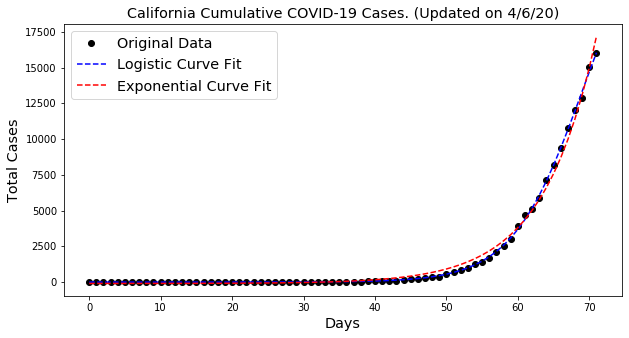



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 14867
	Confirmed cases on 3/30/20 	 4025
	Ratio: 3.69
	Weekly increase: 269.4 %
	Daily increase: 20.5 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9938712786159625
	Doubling Time (during middle of growth):  5.28 (± 1.02 ) days
	param:  [6.72805096e+02 2.62480844e-01 8.63130582e+01 2.60484660e+04]

** Based on Exponential Fit **

	R^2: 0.9823827263562466
	Doubling Time (represents overall growth):  3.53 (± 0.45 ) days
	param:  [100.           0.19615627 100.        ]


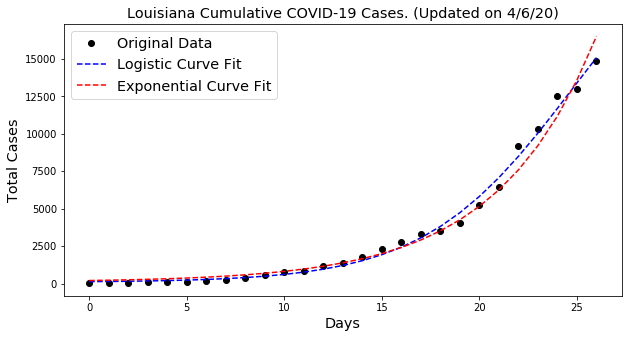



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 13837
	Confirmed cases on 3/30/20 	 5752
	Ratio: 2.41
	Weekly increase: 140.6 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9987272249129462
	Doubling Time (during middle of growth):  5.08 (± 0.23 ) days
	param:  [ 1.66043438e+07  2.73149095e-01 -1.06686483e+01  1.80660764e+04]

** Based on Exponential Fit **

	R^2: 0.9859404150313564
	Doubling Time (represents overall growth):  4.57 (± 0.28 ) days
	param:  [   0.78978084    0.15180803 -100.        ]


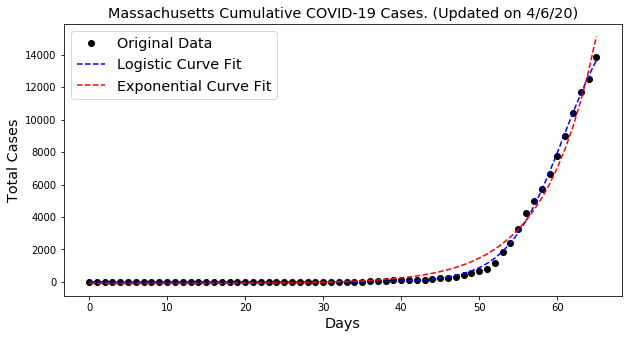



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 13324
	Confirmed cases on 3/30/20 	 5473
	Ratio: 2.43
	Weekly increase: 143.4 %
	Daily increase: 13.6 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.987793449211736
	Doubling Time (during middle of growth):  -9.82 (± -1.19 ) days
	param:  [-1.65027618e-06 -1.41193318e-01 -6.50718946e+07 -4.65811634e+02]

** Based on Exponential Fit **

	R^2: 0.9851556498467969
	Doubling Time (represents overall growth):  4.54 (± 0.45 ) days
	param:  [  71.20476948    0.15259539 -100.        ]


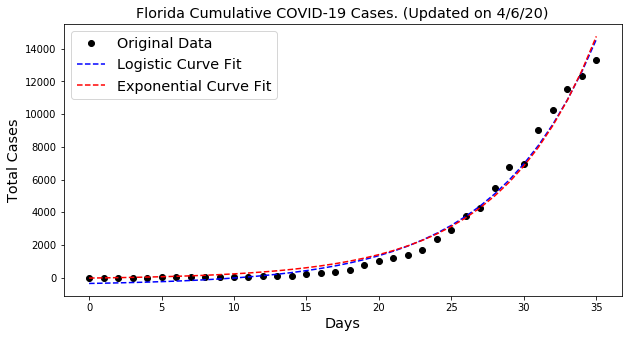



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 13127
	Confirmed cases on 3/30/20 	 4155
	Ratio: 3.16
	Weekly increase: 215.9 %
	Daily increase: 17.9 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.9993152210824351
	Doubling Time (during middle of growth):  5.62 (± 0.32 ) days
	param:  [ 1.82767782e+03  2.46788609e-01 -6.11404057e+01  2.46642908e+04]

** Based on Exponential Fit **

	R^2: 0.9940843824677009
	Doubling Time (represents overall growth):  3.97 (± 0.26 ) days
	param:  [  62.15367691    0.17479105 -100.        ]


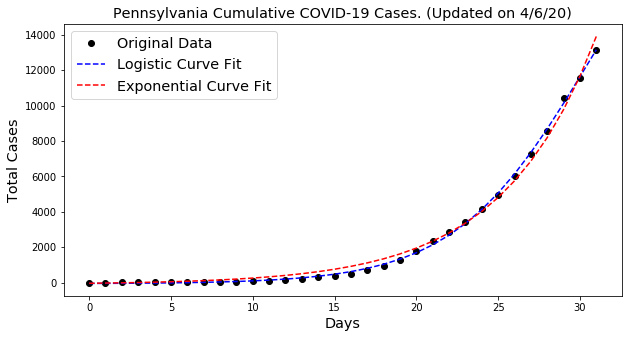



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 12262
	Confirmed cases on 3/30/20 	 5056
	Ratio: 2.43
	Weekly increase: 142.5 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9992147673949264
	Doubling Time (during middle of growth):  5.95 (± 0.21 ) days
	param:  [ 1.27274281e+07  2.33093324e-01 -1.96631827e+01  1.85894379e+04]

** Based on Exponential Fit **

	R^2: 0.9913012094200584
	Doubling Time (represents overall growth):  4.75 (± 0.21 ) days
	param:  [  0.31264978   0.1460744  -99.99993477]


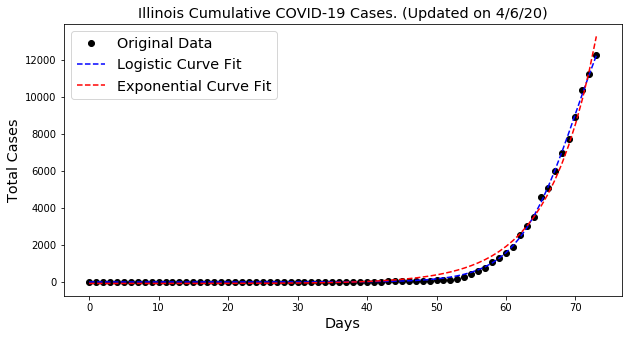



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 8311
	Confirmed cases on 3/30/20 	 4923
	Ratio: 1.69
	Weekly increase: 68.8 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.3 days

** Based on Logistic Fit**

	R^2: 0.999043287184641
	Doubling Time (during middle of growth):  8.72 (± 0.33 ) days
	param:  [ 7.66014954e+04  1.58926767e-01 -2.42310837e+01  1.24737866e+04]

** Based on Exponential Fit **

	R^2: 0.9910553659462491
	Doubling Time (represents overall growth):  7.0 (± 0.33 ) days
	param:  [ 5.44256060e+00  9.89689453e-02 -1.00000000e+02]


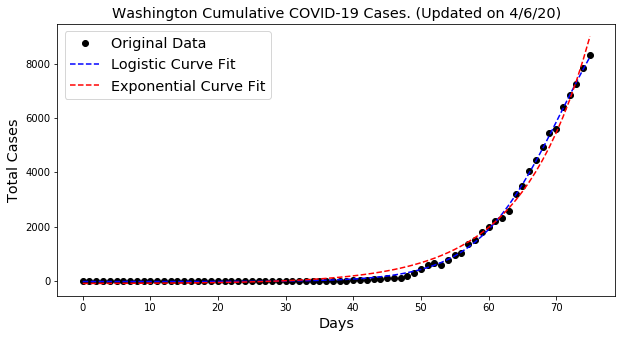



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 8043
	Confirmed cases on 3/30/20 	 3147
	Ratio: 2.56
	Weekly increase: 155.6 %
	Daily increase: 14.3 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.999415983666339
	Doubling Time (during middle of growth):  6.41 (± 0.34 ) days
	param:  [ 6.98634355e+02  2.16174043e-01 -6.48761706e+01  1.35489270e+04]

** Based on Exponential Fit **

	R^2: 0.992356636808375
	Doubling Time (represents overall growth):  4.76 (± 0.37 ) days
	param:  [  82.04538414    0.14556462 -100.        ]


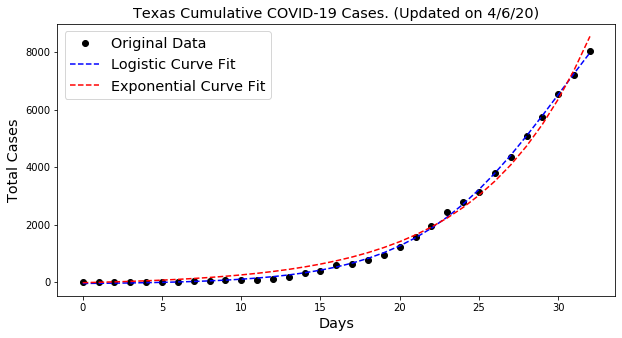



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 7314
	Confirmed cases on 3/30/20 	 2808
	Ratio: 2.6
	Weekly increase: 160.5 %
	Daily increase: 14.7 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.99738652930068
	Doubling Time (during middle of growth):  5.4 (± 0.51 ) days
	param:  [ 1.91749573e+03  2.56523114e-01 -1.91234730e+00  9.54385836e+03]

** Based on Exponential Fit **

	R^2: 0.982307748947072
	Doubling Time (represents overall growth):  5.03 (± 0.58 ) days
	param:  [  74.83465189    0.13792841 -100.        ]


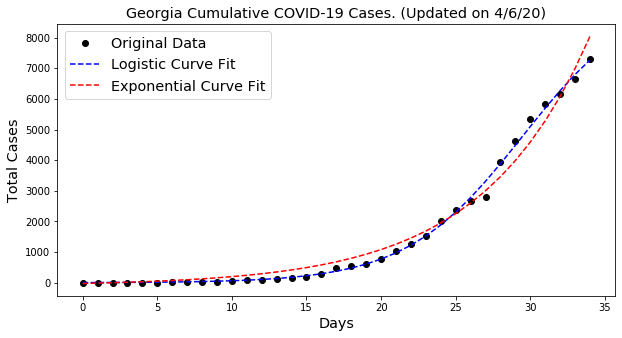



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 6906
	Confirmed cases on 3/30/20 	 2571
	Ratio: 2.69
	Weekly increase: 168.6 %
	Daily increase: 15.2 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9965086558019186
	Doubling Time (during middle of growth):  5.7 (± 0.81 ) days
	param:  [ 4.25894083e+02  2.43298593e-01 -6.79365240e+01  1.06485291e+04]

** Based on Exponential Fit **

	R^2: 0.9881259217779307
	Doubling Time (represents overall growth):  4.37 (± 0.48 ) days
	param:  [ 100.            0.15870871 -100.        ]


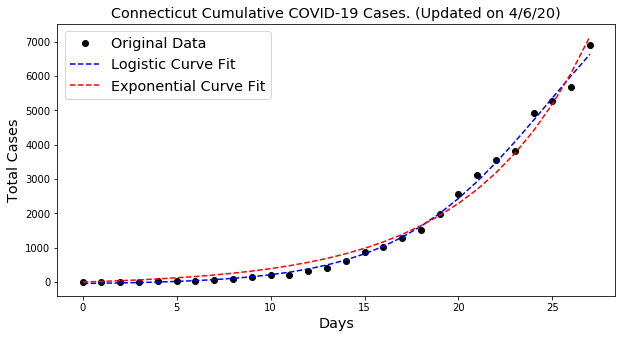



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 5183
	Confirmed cases on 3/30/20 	 2311
	Ratio: 2.24
	Weekly increase: 124.3 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.995803705711166
	Doubling Time (during middle of growth):  7.29 (± 1.13 ) days
	param:  [ 2.56207578e+02  1.90085470e-01 -7.20666320e+01  8.86770077e+03]

** Based on Exponential Fit **

	R^2: 0.9887394769430813
	Doubling Time (represents overall growth):  5.32 (± 0.54 ) days
	param:  [ 100.            0.13023309 -100.        ]


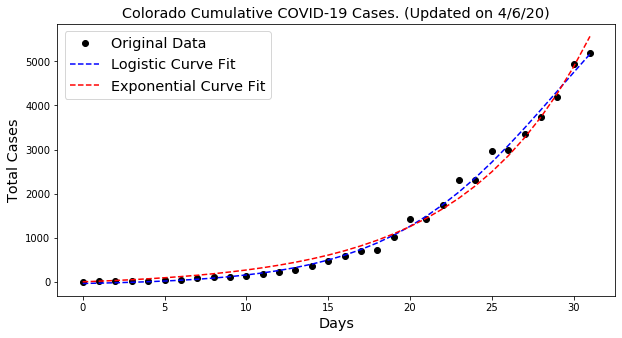



US state:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4956
	Confirmed cases on 3/30/20 	 1786
	Ratio: 2.77
	Weekly increase: 177.5 %
	Daily increase: 15.7 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.999091205101109
	Doubling Time (during middle of growth):  5.16 (± 0.32 ) days
	param:  [ 1.87474846e+03  2.68575207e-01 -3.02024964e+01  7.10793571e+03]

** Based on Exponential Fit **

	R^2: 0.9894703769510784
	Doubling Time (represents overall growth):  4.36 (± 0.39 ) days
	param:  [  39.01812874    0.15901502 -100.        ]


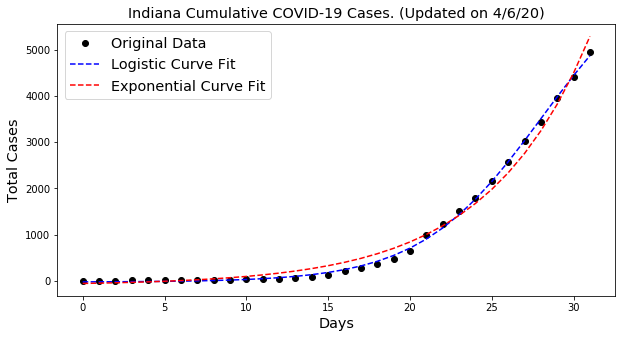



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4453
	Confirmed cases on 3/30/20 	 1933
	Ratio: 2.3
	Weekly increase: 130.4 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9994686920585776
	Doubling Time (during middle of growth):  6.1 (± 0.34 ) days
	param:  [ 2.27299005e+02  2.27427370e-01 -6.18028898e+01  6.61388974e+03]

** Based on Exponential Fit **

	R^2: 0.9875422432513313
	Doubling Time (represents overall growth):  4.79 (± 0.56 ) days
	param:  [ 100.            0.14466145 -100.        ]


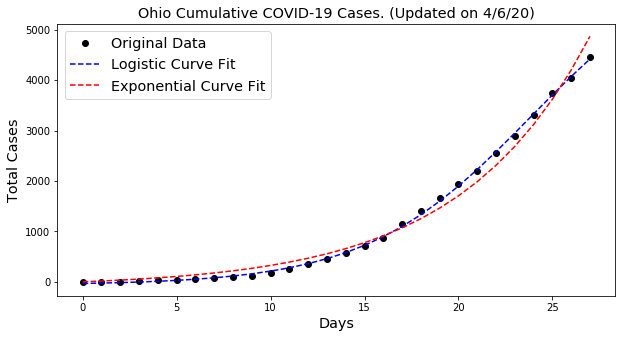



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4045
	Confirmed cases on 3/30/20 	 1413
	Ratio: 2.86
	Weekly increase: 186.3 %
	Daily increase: 16.2 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9994203529870831
	Doubling Time (during middle of growth):  5.99 (± 0.32 ) days
	param:  [ 1.11996538e+03  2.31616272e-01 -1.82972930e+01  7.48559763e+03]

** Based on Exponential Fit **

	R^2: 0.995576587646348
	Doubling Time (represents overall growth):  4.46 (± 0.26 ) days
	param:  [  35.10918095    0.15536321 -100.        ]


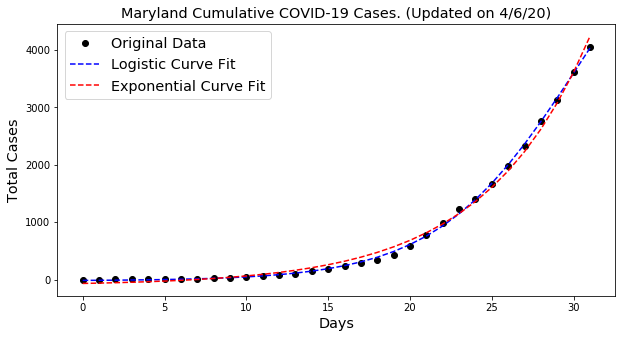



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 3802
	Confirmed cases on 3/30/20 	 1917
	Ratio: 1.98
	Weekly increase: 98.3 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9966987004899941
	Doubling Time (during middle of growth):  5.5 (± 0.59 ) days
	param:  [ 6.28496878e+02  2.51972288e-01 -3.34425469e+01  4.51563407e+03]

** Based on Exponential Fit **

	R^2: 0.9725434644581297
	Doubling Time (represents overall growth):  5.77 (± 0.95 ) days
	param:  [  94.05582363    0.12007761 -100.        ]


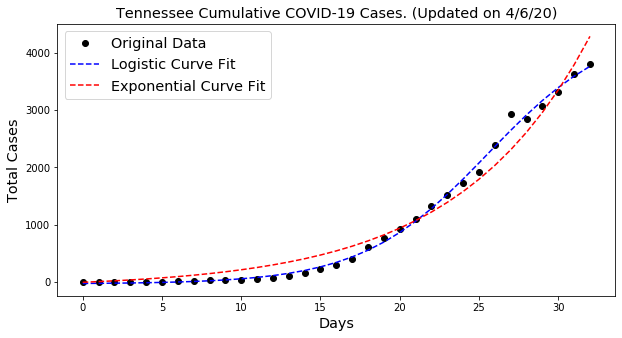



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2962
	Confirmed cases on 3/30/20 	 1313
	Ratio: 2.26
	Weekly increase: 125.6 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9987549116475258
	Doubling Time (during middle of growth):  6.82 (± 0.5 ) days
	param:  [ 5.79162413e+02  2.03194573e-01 -3.42869822e+01  4.63370141e+03]

** Based on Exponential Fit **

	R^2: 0.9920770137917101
	Doubling Time (represents overall growth):  5.54 (± 0.44 ) days
	param:  [  45.93036746    0.1251752  -100.        ]


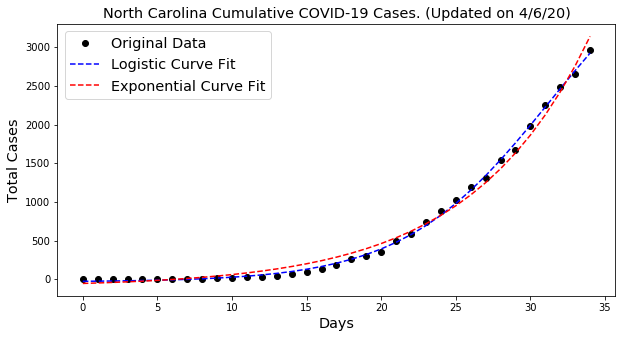



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2878
	Confirmed cases on 3/30/20 	 1020
	Ratio: 2.82
	Weekly increase: 182.2 %
	Daily increase: 16.0 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9992824766435308
	Doubling Time (during middle of growth):  6.04 (± 0.38 ) days
	param:  [ 6.20534072e+02  2.29558035e-01 -2.74473395e+00  5.25059491e+03]

** Based on Exponential Fit **

	R^2: 0.9952934431178884
	Doubling Time (represents overall growth):  4.74 (± 0.31 ) days
	param:  [ 45.5070133    0.14615794 -97.77005764]


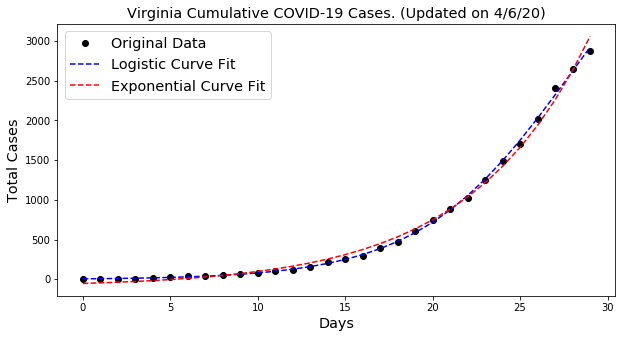



US state:  Missouri

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2736
	Confirmed cases on 3/30/20 	 1051
	Ratio: 2.6
	Weekly increase: 160.3 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9957275519749718
	Doubling Time (during middle of growth):  5.25 (± 0.72 ) days
	param:  [ 6.92825630e+02  2.64265836e-01 -3.10672212e+01  3.50693458e+03]

** Based on Exponential Fit **

	R^2: 0.9828107195395052
	Doubling Time (represents overall growth):  4.95 (± 0.65 ) days
	param:  [  51.76413199    0.14010973 -100.        ]


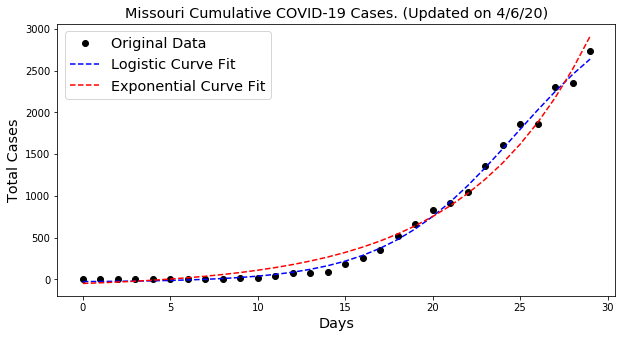



US state:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2732
	Confirmed cases on 3/30/20 	 1157
	Ratio: 2.36
	Weekly increase: 136.1 %
	Daily increase: 13.1 % per day
	Doubling Time (represents recent growth): 5.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9897655482313167
	Doubling Time (represents overall growth):  4.62 (± 0.23 ) days
	param:  [  0.06945863   0.15012399 -25.05408176]


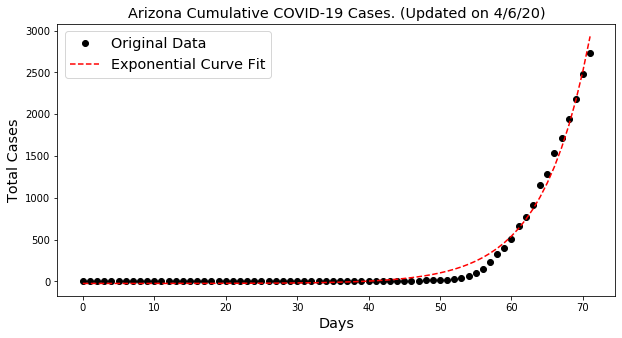



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2449
	Confirmed cases on 3/30/20 	 1230
	Ratio: 1.99
	Weekly increase: 99.1 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9975722417438729
	Doubling Time (during middle of growth):  7.74 (± 1.1 ) days
	param:  [ 6.39007715e+01  1.79138383e-01 -9.35259098e+01  3.71508930e+03]

** Based on Exponential Fit **

	R^2: 0.9793451005297635
	Doubling Time (represents overall growth):  5.62 (± 0.93 ) days
	param:  [100.           0.12326909 -63.11128779]


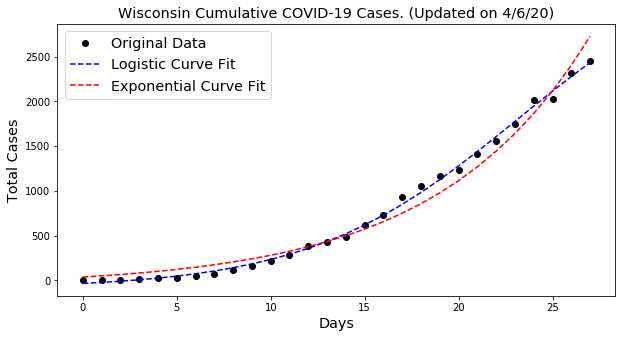



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2232
	Confirmed cases on 3/30/20 	 925
	Ratio: 2.41
	Weekly increase: 141.3 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.998579782111263
	Doubling Time (during middle of growth):  6.08 (± 0.51 ) days
	param:  [ 4.82774633e+02  2.27834058e-01 -1.00939553e+01  3.42793602e+03]

** Based on Exponential Fit **

	R^2: 0.9917598238252004
	Doubling Time (represents overall growth):  5.35 (± 0.48 ) days
	param:  [  51.35681571    0.12955212 -100.        ]


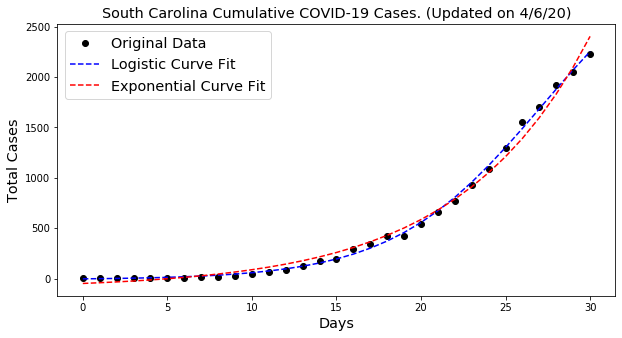



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1953
	Confirmed cases on 3/30/20 	 1012
	Ratio: 1.93
	Weekly increase: 93.0 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9976965509283708
	Doubling Time (during middle of growth):  5.18 (± 0.47 ) days
	param:  [1.17231679e+03 2.67494232e-01 1.54573419e+00 2.38483012e+03]

** Based on Exponential Fit **

	R^2: 0.9820776143000587
	Doubling Time (represents overall growth):  5.77 (± 0.75 ) days
	param:  [  48.5163054     0.12009622 -100.        ]


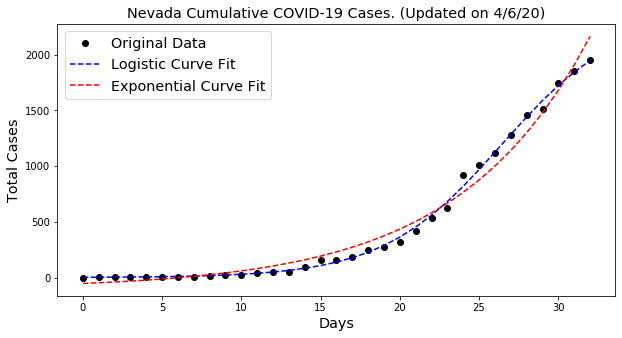



US state:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1952
	Confirmed cases on 3/30/20 	 899
	Ratio: 2.17
	Weekly increase: 117.1 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9956161043396686
	Doubling Time (during middle of growth):  7.69 (± 1.79 ) days
	param:  [ 5.83539942e+01  1.80170720e-01 -8.56055113e+01  3.49241775e+03]

** Based on Exponential Fit **

	R^2: 0.9871232116957324
	Doubling Time (represents overall growth):  5.39 (± 0.78 ) days
	param:  [100.           0.12849485 -92.97088997]


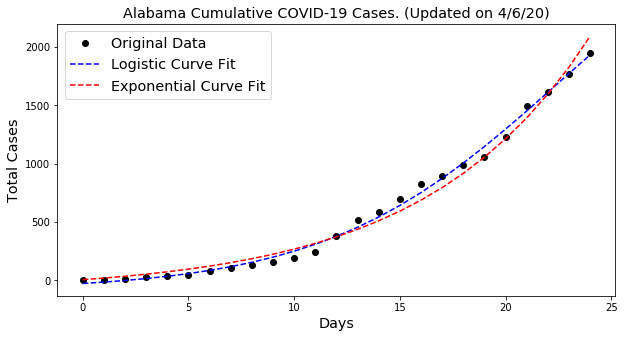



US state:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1738
	Confirmed cases on 3/30/20 	 847
	Ratio: 2.05
	Weekly increase: 105.2 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.998049050125481
	Doubling Time (during middle of growth):  7.65 (± 1.09 ) days
	param:  [ 5.49020896e+01  1.81231599e-01 -8.66004546e+01  2.80856781e+03]

** Based on Exponential Fit **

	R^2: 0.9870653027560168
	Doubling Time (represents overall growth):  5.79 (± 0.84 ) days
	param:  [ 100.            0.11971749 -100.        ]


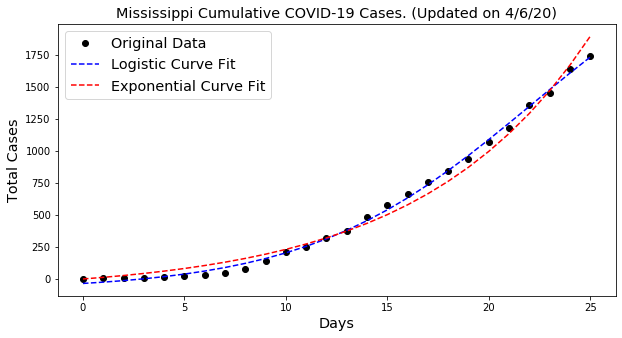



US state:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1680
	Confirmed cases on 3/30/20 	 804
	Ratio: 2.09
	Weekly increase: 109.0 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9960384644880942
	Doubling Time (during middle of growth):  7.41 (± 1.18 ) days
	param:  [ 2.09308172e+02  1.87028949e-01 -3.72455213e+01  3.02285819e+03]

** Based on Exponential Fit **

	R^2: 0.9920869250702491
	Doubling Time (represents overall growth):  5.86 (± 0.54 ) days
	param:  [  54.40813818    0.11823677 -100.        ]


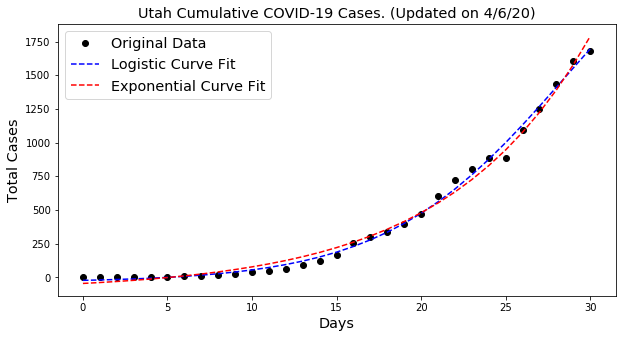



US state:  Oklahoma

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1329
	Confirmed cases on 3/30/20 	 481
	Ratio: 2.76
	Weekly increase: 176.3 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9973343260745836
	Doubling Time (during middle of growth):  5.3 (± 0.57 ) days
	param:  [ 1.13604614e+03  2.61396360e-01 -5.08579209e+00  1.96555305e+03]

** Based on Exponential Fit **

	R^2: 0.988479744880455
	Doubling Time (represents overall growth):  4.88 (± 0.49 ) days
	param:  [ 21.40442676   0.14198761 -61.79671137]


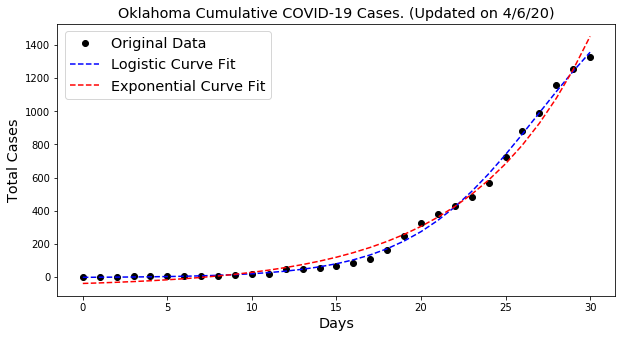



US state:  Idaho

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1101
	Confirmed cases on 3/30/20 	 340
	Ratio: 3.24
	Weekly increase: 223.8 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9955158614708234
	Doubling Time (during middle of growth):  3.66 (± 0.52 ) days
	param:  [1.59215974e+03 3.79183907e-01 1.47362453e+01 1.34401978e+03]

** Based on Exponential Fit **

	R^2: 0.9759534167691599
	Doubling Time (represents overall growth):  4.8 (± 0.88 ) days
	param:  [ 41.7395955    0.14437386 -83.72092163]


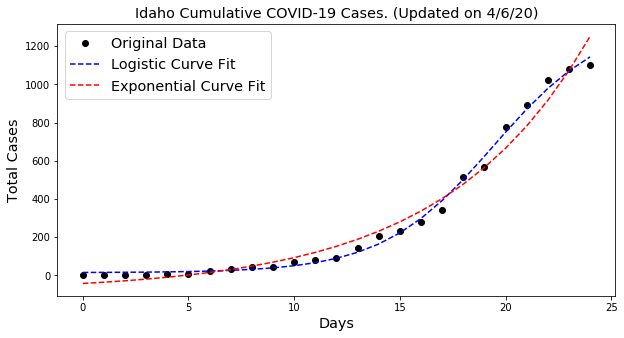



US state:  District of Columbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1097
	Confirmed cases on 3/30/20 	 401
	Ratio: 2.74
	Weekly increase: 173.6 %
	Daily increase: 15.5 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9984316597136569
	Doubling Time (during middle of growth):  8.15 (± 1.71 ) days
	param:  [ 5.73280494e+01  1.70149742e-01 -3.53538539e+01  3.30818423e+03]

** Based on Exponential Fit **

	R^2: 0.9978326259619772
	Doubling Time (represents overall growth):  5.54 (± 0.41 ) days
	param:  [100.           0.12512671 -86.66667906]


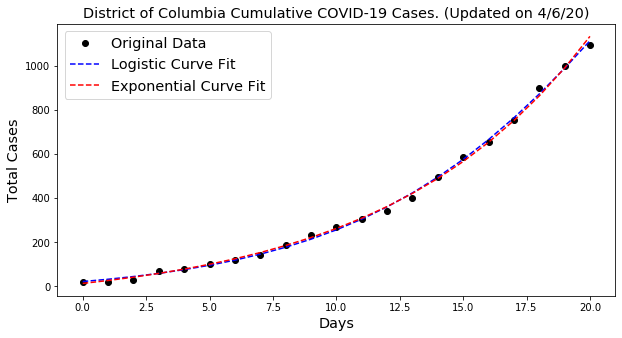



US state:  Rhode Island

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1082
	Confirmed cases on 3/30/20 	 408
	Ratio: 2.65
	Weekly increase: 165.2 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9976070081166694
	Doubling Time (during middle of growth):  6.15 (± 0.6 ) days
	param:  [2.77387506e+03 2.25496876e-01 5.56096113e-01 1.92299295e+03]

** Based on Exponential Fit **

	R^2: 0.9938715070847162
	Doubling Time (represents overall growth):  4.6 (± 0.28 ) days
	param:  [  4.99404061   0.15054284 -19.64730529]


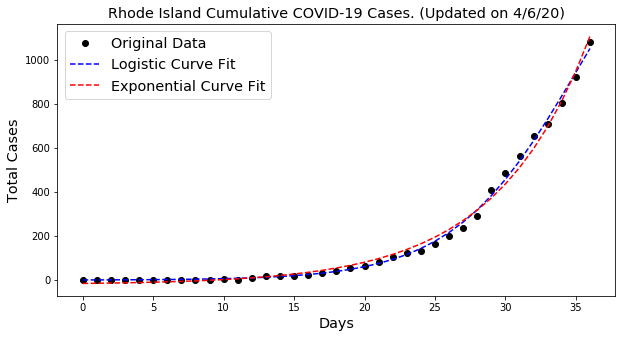



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1068
	Confirmed cases on 3/30/20 	 606
	Ratio: 1.76
	Weekly increase: 76.2 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9978139239991062
	Doubling Time (during middle of growth):  6.15 (± 0.5 ) days
	param:  [1.05595359e+03 2.25427829e-01 1.79358014e+00 1.33848517e+03]

** Based on Exponential Fit **

	R^2: 0.9843170135190046
	Doubling Time (represents overall growth):  6.85 (± 0.77 ) days
	param:  [ 29.52117304   0.10114845 -67.51244202]


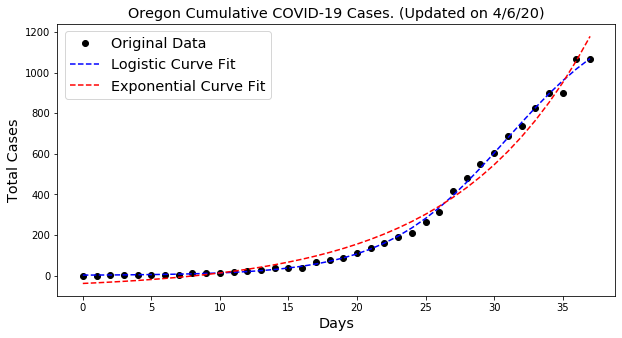



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 986
	Confirmed cases on 3/30/20 	 576
	Ratio: 1.71
	Weekly increase: 71.2 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9990475152506608
	Doubling Time (during middle of growth):  7.4 (± 0.52 ) days
	param:  [ 1.15834894e+02  1.87408088e-01 -2.25916878e+01  1.32120448e+03]

** Based on Exponential Fit **

	R^2: 0.9900095509145861
	Doubling Time (represents overall growth):  7.7 (± 0.91 ) days
	param:  [ 7.12288817e+01  9.00335368e-02 -1.00000000e+02]


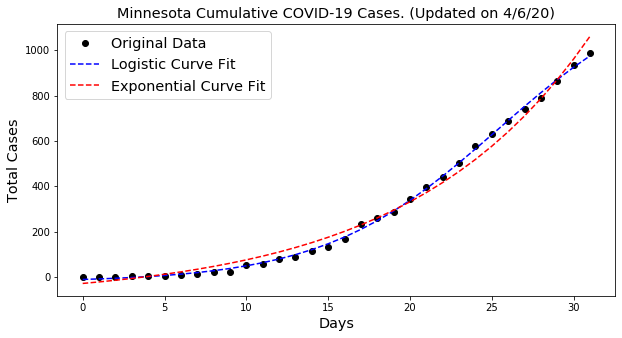



US state:  Kentucky

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 955
	Confirmed cases on 3/30/20 	 479
	Ratio: 1.99
	Weekly increase: 99.4 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9968972339338558
	Doubling Time (during middle of growth):  5.25 (± 0.56 ) days
	param:  [7.39273939e+02 2.64078796e-01 5.20112911e-01 1.18332094e+03]

** Based on Exponential Fit **

	R^2: 0.980096881137794
	Doubling Time (represents overall growth):  6.49 (± 0.97 ) days
	param:  [ 42.69784713   0.10673178 -85.37979606]


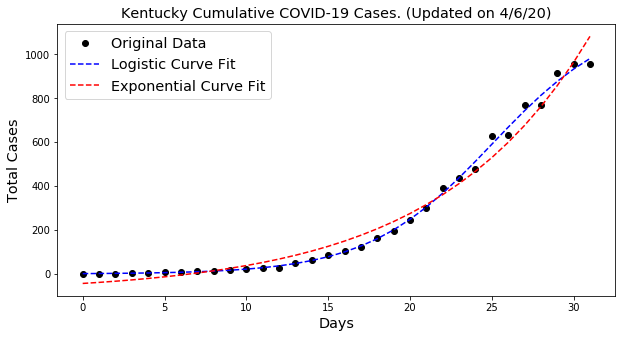



US state:  Iowa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 946
	Confirmed cases on 3/30/20 	 424
	Ratio: 2.23
	Weekly increase: 123.1 %
	Daily increase: 12.1 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9991456006826532
	Doubling Time (during middle of growth):  5.86 (± 0.39 ) days
	param:  [3.40304519e+02 2.36369721e-01 2.24541629e+00 1.36451905e+03]

** Based on Exponential Fit **

	R^2: 0.9920226925993991
	Doubling Time (represents overall growth):  5.59 (± 0.54 ) days
	param:  [ 32.82935667   0.12395166 -54.45152554]


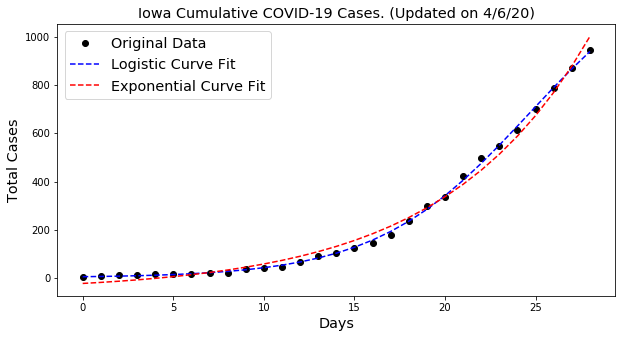



US state:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 875
	Confirmed cases on 3/30/20 	 473
	Ratio: 1.85
	Weekly increase: 85.0 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9945223247332459
	Doubling Time (during middle of growth):  10.66 (± 4.06 ) days
	param:  [ 1.60419635e+01  1.30066873e-01 -1.27389530e+02  1.57449649e+03]

** Based on Exponential Fit **

	R^2: 0.9786940573020393
	Doubling Time (represents overall growth):  7.11 (± 1.62 ) days
	param:  [ 1.00000000e+02  9.74352474e-02 -8.32195700e+01]


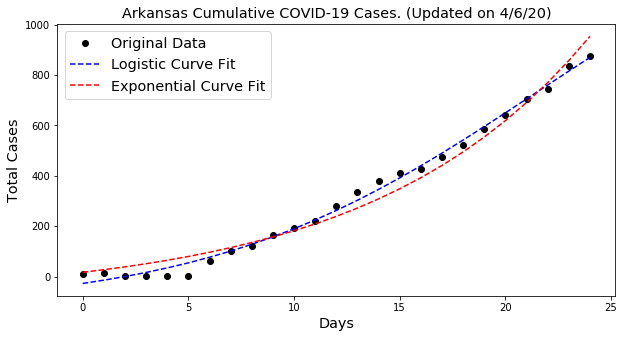



US state:  Kansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 849
	Confirmed cases on 3/30/20 	 372
	Ratio: 2.28
	Weekly increase: 128.2 %
	Daily increase: 12.5 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9990196383200901
	Doubling Time (during middle of growth):  5.96 (± 0.42 ) days
	param:  [ 3.76348703e+02  2.32717528e-01 -6.37605210e+00  1.19862840e+03]

** Based on Exponential Fit **

	R^2: 0.9916108905366867
	Doubling Time (represents overall growth):  5.69 (± 0.55 ) days
	param:  [ 27.4974306    0.12191661 -55.3265335 ]


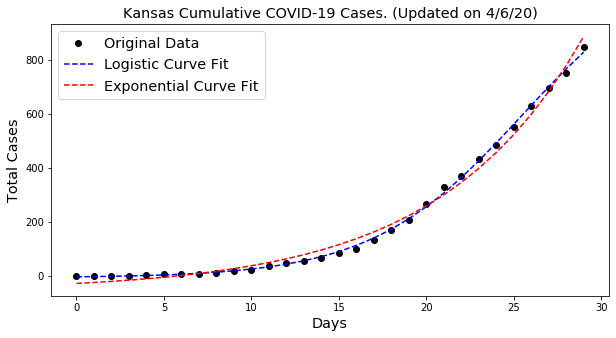



US state:  Delaware

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 783
	Confirmed cases on 3/30/20 	 264
	Ratio: 2.97
	Weekly increase: 196.6 %
	Daily increase: 16.8 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.996604668935866
	Doubling Time (during middle of growth):  9.39 (± nan ) days
	param:  [ 3.74099948e+08  1.47694199e-01 -2.29935578e+01  6.43950611e+09]

** Based on Exponential Fit **

	R^2: 0.996604669119235
	Doubling Time (represents overall growth):  4.69 (± 0.29 ) days
	param:  [ 17.21333358   0.14769419 -22.99356088]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



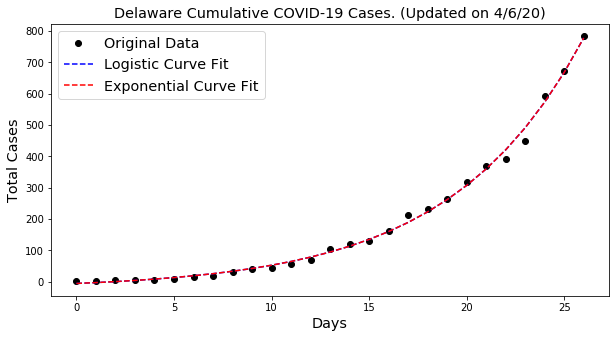



US state:  New Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 757
	Confirmed cases on 3/30/20 	 237
	Ratio: 3.19
	Weekly increase: 219.4 %
	Daily increase: 18.0 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.9944178523977718
	Doubling Time (during middle of growth):  8.25 (± 2.28 ) days
	param:  [ 4.58435945e+02  1.68037471e-01 -7.54800220e+00  5.21894228e+03]

** Based on Exponential Fit **

	R^2: 0.9942941178948508
	Doubling Time (represents overall growth):  4.57 (± 0.36 ) days
	param:  [ 15.1598172    0.15159708 -14.34552058]


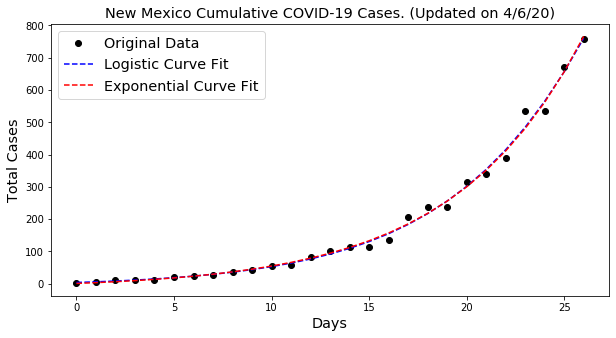



US state:  New Hampshire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 715
	Confirmed cases on 3/30/20 	 314
	Ratio: 2.28
	Weekly increase: 127.7 %
	Daily increase: 12.5 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.988674510575692
	Doubling Time (during middle of growth):  9.15 (± 2.65 ) days
	param:  [ 1.40699989e+03  1.51494225e-01 -9.34423307e+00  5.73952340e+03]

** Based on Exponential Fit **

	R^2: 0.9885697899998067
	Doubling Time (represents overall growth):  4.94 (± 0.43 ) days
	param:  [  5.37511425   0.14021413 -12.64281669]


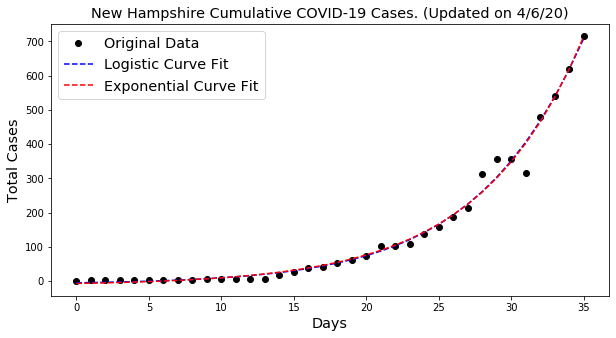



US state:  Vermont

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 543
	Confirmed cases on 3/30/20 	 256
	Ratio: 2.12
	Weekly increase: 112.1 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9947442793126354
	Doubling Time (during middle of growth):  7.98 (± 1.61 ) days
	param:  [ 1.20905439e+02  1.73774783e-01 -1.81992868e+01  9.76452882e+02]

** Based on Exponential Fit **

	R^2: 0.991529925352846
	Doubling Time (represents overall growth):  6.61 (± 0.7 ) days
	param:  [ 29.38936075   0.10489285 -50.42782327]


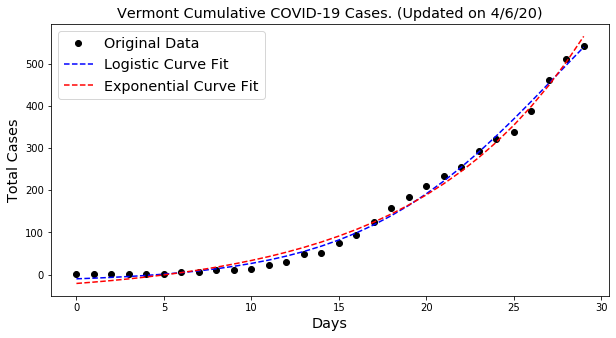



US state:  Puerto Rico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 513
	Confirmed cases on 3/30/20 	 174
	Ratio: 2.95
	Weekly increase: 194.8 %
	Daily increase: 16.7 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.9916469748676704
	Doubling Time (during middle of growth):  4.62 (± 1.15 ) days
	param:  [2.04793299e+02 3.00181063e-01 9.45756482e-01 7.09348438e+02]

** Based on Exponential Fit **

	R^2: 0.9833164017393418
	Doubling Time (represents overall growth):  4.94 (± 0.89 ) days
	param:  [ 31.25144706   0.14027563 -45.24371152]


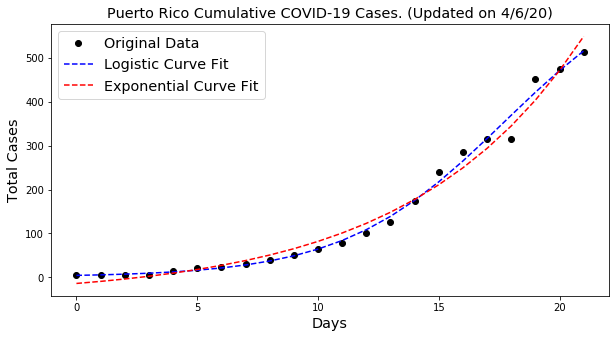



US state:  Maine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 499
	Confirmed cases on 3/30/20 	 275
	Ratio: 1.81
	Weekly increase: 81.5 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9955382201321706
	Doubling Time (during middle of growth):  8.6 (± 2.09 ) days
	param:  [ 3.46650070e+01  1.61125608e-01 -2.64243608e+01  8.40045525e+02]

** Based on Exponential Fit **

	R^2: 0.9925406576115282
	Doubling Time (represents overall growth):  8.76 (± 1.29 ) days
	param:  [ 8.71639201e+01  7.91553680e-02 -1.00000000e+02]


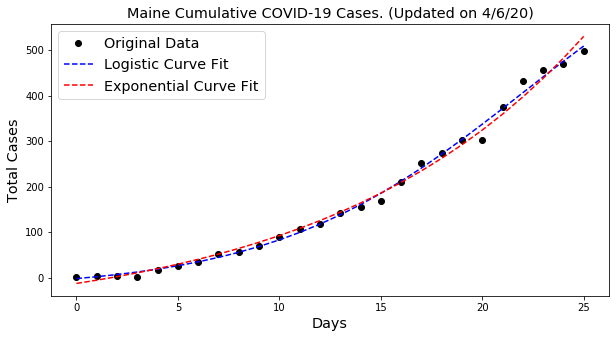



US state:  Nebraska

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 417
	Confirmed cases on 3/30/20 	 145
	Ratio: 2.88
	Weekly increase: 187.6 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9969235412092333
	Doubling Time (during middle of growth):  7.88 (± 1.21 ) days
	param:  [8.00504220e+02 1.75899970e-01 3.30415496e+00 1.85102231e+03]

** Based on Exponential Fit **

	R^2: 0.9965845079858188
	Doubling Time (represents overall growth):  4.6 (± 0.24 ) days
	param:  [ 4.00830515  0.15060419 -1.10634826]


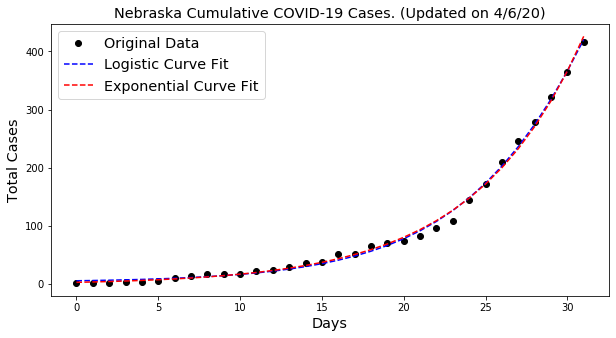



US state:  Hawaii

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 387
	Confirmed cases on 3/30/20 	 175
	Ratio: 2.21
	Weekly increase: 121.1 %
	Daily increase: 12.0 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9948890123080901
	Doubling Time (during middle of growth):  7.6 (± 1.4 ) days
	param:  [ 1.95245597e+02  1.82434765e-01 -6.39659989e+00  7.34541637e+02]

** Based on Exponential Fit **

	R^2: 0.9913714712578282
	Doubling Time (represents overall growth):  6.16 (± 0.61 ) days
	param:  [ 15.21880716   0.11249143 -26.56010288]


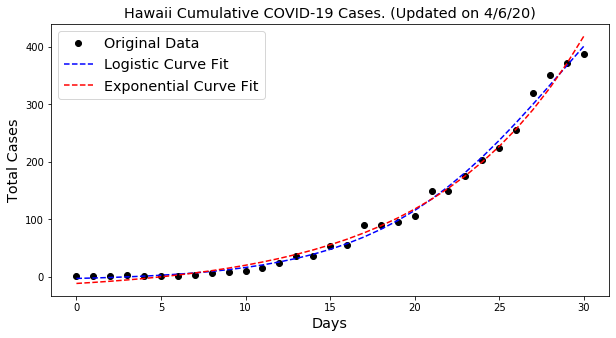



US state:  West Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 345
	Confirmed cases on 3/30/20 	 145
	Ratio: 2.38
	Weekly increase: 137.9 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9971410555873116
	Doubling Time (during middle of growth):  6.25 (± 1.35 ) days
	param:  [ 4.03672217e+01  2.21659973e-01 -1.71840090e+01  5.63061314e+02]

** Based on Exponential Fit **

	R^2: 0.9937769900967712
	Doubling Time (represents overall growth):  6.45 (± 0.98 ) days
	param:  [ 55.4353536    0.10743798 -67.34640488]


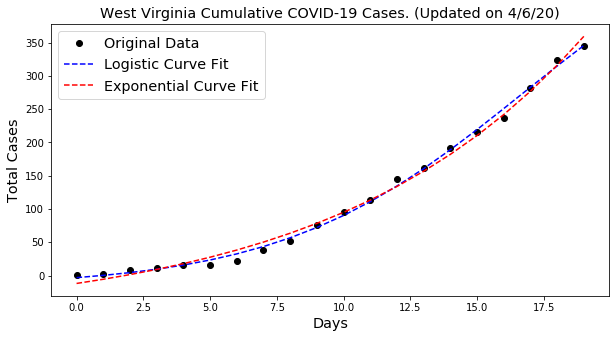



US state:  Montana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 299
	Confirmed cases on 3/30/20 	 171
	Ratio: 1.75
	Weekly increase: 74.9 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9980179360031866
	Doubling Time (during middle of growth):  5.03 (± 0.51 ) days
	param:  [ 1.01079598e+02  2.75877537e-01 -2.23095825e+00  3.32827647e+02]

** Based on Exponential Fit **

	R^2: 0.9810816034380263
	Doubling Time (represents overall growth):  9.32 (± 2.45 ) days
	param:  [ 6.84655885e+01  7.43460274e-02 -8.53076126e+01]


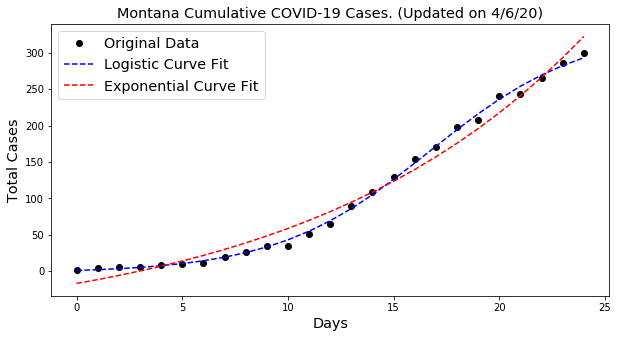



US state:  South Dakota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 288
	Confirmed cases on 3/30/20 	 101
	Ratio: 2.85
	Weekly increase: 185.1 %
	Daily increase: 16.1 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9977063478505412
	Doubling Time (during middle of growth):  6.91 (± 1.01 ) days
	param:  [3.39605878e+02 2.00692326e-01 2.72345497e+00 7.97579711e+02]

** Based on Exponential Fit **

	R^2: 0.9966726192864029
	Doubling Time (represents overall growth):  4.48 (± 0.27 ) days
	param:  [ 5.22241332  0.15479912 -3.03298275]


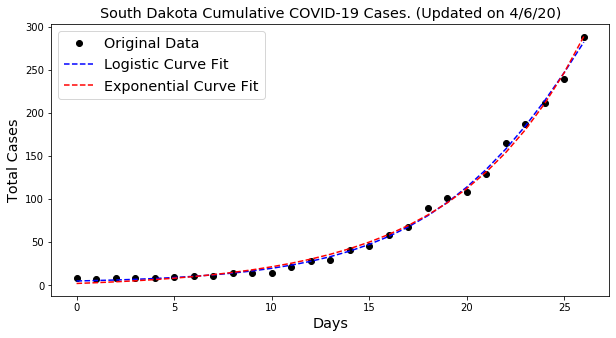



US state:  North Dakota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 225
	Confirmed cases on 3/30/20 	 109
	Ratio: 2.06
	Weekly increase: 106.4 %
	Daily increase: 10.9 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9959345148460441
	Doubling Time (during middle of growth):  7.24 (± 1.4 ) days
	param:  [ 6.34223662e+01  1.91567634e-01 -6.63058968e+00  3.43409637e+02]

** Based on Exponential Fit **

	R^2: 0.99176805684618
	Doubling Time (represents overall growth):  7.47 (± 1.02 ) days
	param:  [ 26.28085477   0.09281495 -34.15261357]


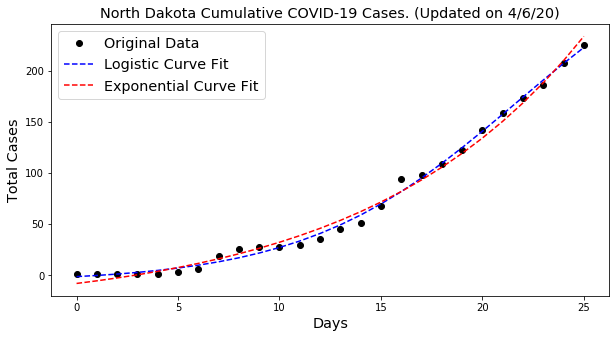



US state:  Wyoming

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 210
	Confirmed cases on 3/30/20 	 94
	Ratio: 2.23
	Weekly increase: 123.4 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9960450336250746
	Doubling Time (during middle of growth):  7.16 (± 1.37 ) days
	param:  [ 7.78187215e+01  1.93668070e-01 -3.04188453e+00  3.46221416e+02]

** Based on Exponential Fit **

	R^2: 0.992255118263145
	Doubling Time (represents overall growth):  6.87 (± 0.85 ) days
	param:  [ 19.81110397   0.10091731 -24.38484102]


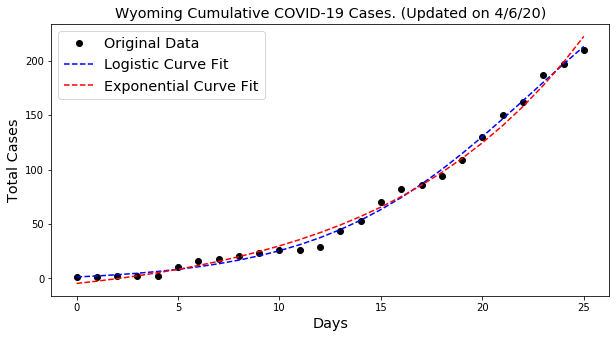



US state:  Alaska

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 137
	Confirmed cases on 3/30/20 	 114
	Ratio: 1.2
	Weekly increase: 20.2 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 26.4 days

** Based on Logistic Fit**

	R^2: 0.9816225371302805
	Doubling Time (during middle of growth):  4.0 (± 1.11 ) days
	param:  [202.35728314   0.34675654   0.4628479  174.22581472]

 exponential R^2  0.9446854406091582


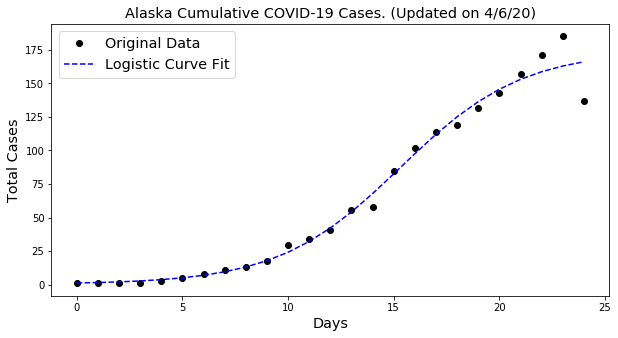



US state:  Guam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 113
	Confirmed cases on 3/30/20 	 58
	Ratio: 1.95
	Weekly increase: 94.8 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9909571006788839
	Doubling Time (during middle of growth):  31.66 (± 65.87 ) days
	param:  [ 9.34963057e+05  4.37929807e-02 -7.27912418e+01  6.90402906e+07]

** Based on Exponential Fit **

	R^2: 0.9909571026869242
	Doubling Time (represents overall growth):  15.83 (± 5.61 ) days
	param:  [ 7.38429554e+01  4.37928978e-02 -7.27913219e+01]


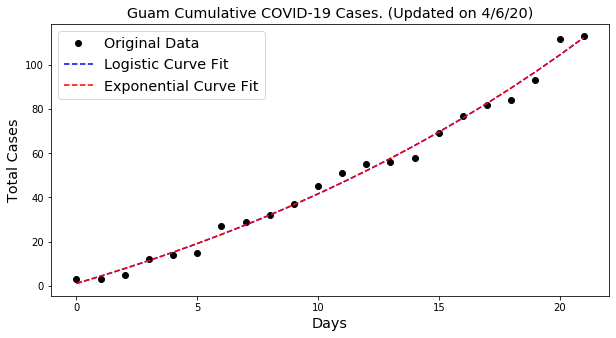



US state:  Grand Princess

** Based on Logistic Fit**

	R^2: 0.9959740662202496
	Doubling Time (during middle of growth):  0.13 (± 2.27 ) days
	param:  [1.66494756e+54 1.10652433e+01 2.47272426e+01 1.03002804e+02]

 exponential R^2  0.7813048051038171


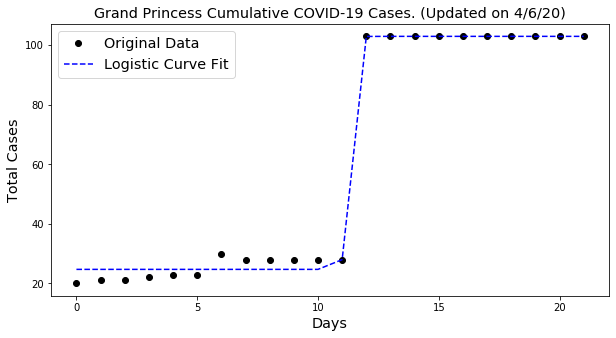

In [5]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


    Recent Doubling Time  Inferred Doubling Time  95%CI
0                    7.1                     6.4    0.5
1                    5.4                     5.3    0.3
2                    5.0                     5.6    0.3
3                    6.0                     6.9    0.2
4                    3.7                     5.3    1.0
5                    5.5                     5.1    0.2
6                    5.5                     4.5    0.4
7                    4.2                     5.6    0.3
8                    5.5                     5.9    0.2
9                    9.3                     8.7    0.3
10                   5.2                     6.4    0.3
11                   5.1                     5.4    0.5
12                   4.9                     5.7    0.8
13      

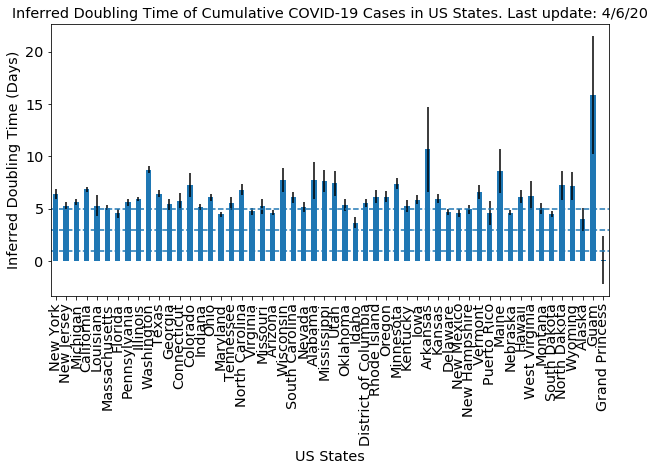

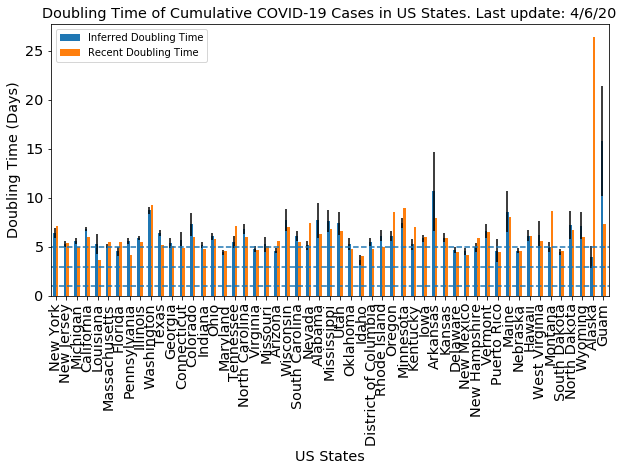

In [6]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()